In [30]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import SimpleITK as stk
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage import measure

In [31]:
root = "/Users/STUFF/lungnode/"
target_root = "/Users/STUFF/Processedm2/Processed_Data/"

In [32]:
subset = 9   #runn: 0..9
file_list = glob(root+f"subset{subset}/*.mhd")
annotations_df = pd.read_csv(root+"annotations.csv")
print("Files Count:",len(file_list))
print("DF Count:",len(annotations_df))
annotations_df.head()

Files Count: 88
DF Count: 1186


,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


(array([2., 1., 0., ..., 0., 0., 1.]),
 array([ 3.2534432 ,  3.27792977,  3.30241634, ..., 32.22105711,
        32.24554368, 32.27003025]),
 <BarContainer object of 1185 artists>)

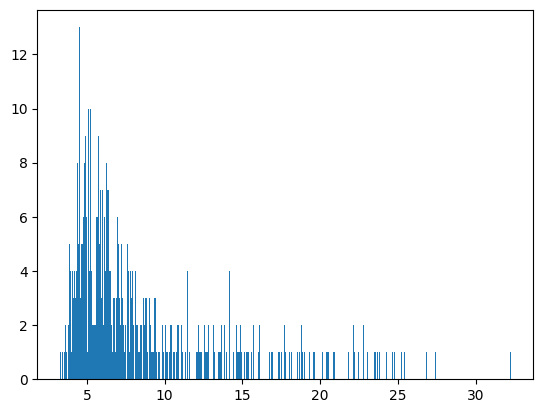

In [33]:
d = annotations_df['diameter_mm'].values
plt.hist(d, bins=1185)

In [34]:
def get_filename(file_list, file):
    for f in file_list:
        if file in f:
            return f

In [35]:
annotations_df["filename"] = annotations_df["seriesuid"].map(lambda file: get_filename(file_list, file))
annotations_df = annotations_df.dropna()
annotations_df = annotations_df[annotations_df['diameter_mm']>=4]  # Excluding nodules with diameter less than 4mm
print(len(annotations_df))

99


In [36]:
def load_mhd(file):
    mhdimage = stk.ReadImage(file)
    ct_scan = stk.GetArrayFromImage(mhdimage)
    origin = np.array(list(mhdimage.GetOrigin()))
    space = np.array(list(mhdimage.GetSpacing()))
    return ct_scan, origin, space

In [37]:
def make_mask(img, center, diam):
    mask = np.zeros_like(img, dtype=np.uint8)
    mask = cv2.circle(mask, (int(center[0]),int(center[1])), diam//2, 255, -1)
    return mask

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # CLAHE(Contrast Limited Adaptive Histogram Equalization) filter for enhancing the contrast of an image

# Iterating over all the files in the subset
for i,file in tqdm(enumerate(np.unique(annotations_df['filename'].values))):
    annotations = annotations_df[annotations_df["filename"]==file]
    ct, origin, space = load_mhd(file)      # Loading the CT scan
    num_z, height, width = ct.shape
    ct_norm = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)   
    for idx, row in annotations.iterrows():
        node_x = int(row["coordX"])         
        node_y = int(row["coordY"])         
        node_z = int(row["coordZ"])         
        diam = int(row["diameter_mm"])      

        center = np.array([node_x, node_y, node_z]) 
        v_center = np.rint((center-origin)/space)   

        img_norm = ct_norm[int(v_center[2]),:,:]       
        img_norm = cv2.resize(img_norm, (512,512))     
        img_norm_improved = clahe.apply(img_norm.astype(np.uint8))

        ################################################################################################
        v_diam = int(diam/space[0])+5       
        mask = make_mask(img_norm, v_center, v_diam)    
        if v_diam>18:          
            img_norm2 = ct_norm[(int(v_center[2])-1),:,:]
            img_norm2 = cv2.resize(img_norm2, (512,512))
            img_norm2_improved = clahe.apply(img_norm2.astype(np.uint8))
            mask2 = make_mask(img_norm2, v_center, v_diam-1)
            
            img_norm3 = ct_norm[(int(v_center[2])+1),:,:]
            img_norm3 = cv2.resize(img_norm3, (512,512))
            img_norm3_improved = clahe.apply(img_norm3.astype(np.uint8))
            mask3 = make_mask(img_norm3, v_center, v_diam-1)

        ################################################################################################

        # Calculating the threshold 
        centeral_area = img_norm[100:400, 100:400]
        kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
        centroids = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centroids)
        
        ################################################################################################
        
        mask = cv2.bitwise_and(img_norm, img_norm, mask=mask)
        _, mask = cv2.threshold(mask, threshold-5, 255, cv2.THRESH_BINARY)
        if v_diam>18:
            mask2 = cv2.bitwise_and(img_norm2, img_norm2, mask=mask2)
            _, mask2 = cv2.threshold(mask2, threshold-5, 255, cv2.THRESH_BINARY)
            
            mask3 = cv2.bitwise_and(img_norm3, img_norm3, mask=mask3)
            _, mask3 = cv2.threshold(mask3, threshold-5, 255, cv2.THRESH_BINARY)

        ################################################################################################
        
        # segmenting the lungs from CT scan slices

        ret, lung_roi = cv2.threshold(img_norm, threshold, 255, cv2.THRESH_BINARY_INV)
        lung_roi = cv2.erode(lung_roi, kernel=np.ones([4,4]))
        lung_roi = cv2.dilate(lung_roi, kernel=np.ones([13,13]))
        lung_roi = cv2.erode(lung_roi, kernel=np.ones([8,8]))

        labels = measure.label(lung_roi)       
        regions = measure.regionprops(labels)  
        good_labels = []
        for prop in regions:        
            
            B = prop.bbox
            
            if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
                good_labels.append(prop.label)
        lung_roi_mask = np.zeros_like(labels)
        for N in good_labels:
            lung_roi_mask = lung_roi_mask + np.where(labels == N, 1, 0)

        #  proper segmentation
        contours, hirearchy = cv2.findContours(lung_roi_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        external_contours = np.zeros(lung_roi_mask.shape)
        for i in range(len(contours)):
            if hirearchy[0][i][3] == -1:
                area = cv2.contourArea(contours[i])
                if area>518.0:
                    cv2.drawContours(external_contours,contours,i,(1,1,1),-1)
        external_contours = cv2.dilate(external_contours, kernel=np.ones([4,4]))
        
        external_contours = cv2.bitwise_not(external_contours.astype(np.uint8))
        external_contours = cv2.erode(external_contours, kernel=np.ones((7,7)))
        external_contours = cv2.bitwise_not(external_contours)
        external_contours = cv2.dilate(external_contours, kernel=np.ones((12,12)))
        external_contours = cv2.erode(external_contours, kernel=np.ones((12,12)))
        
        img_norm_improved = img_norm_improved.astype(np.uint8)
        external_contours = external_contours.astype(np.uint8)      
        # Final segmentated lungs mask
        extracted_lungs = cv2.bitwise_and(img_norm_improved, img_norm_improved, mask=external_contours)
        
        #------------------------------------------------------------------------------------------------------------#
        if v_diam>18:
            img_norm2_improved = img_norm2_improved.astype(np.uint8)
            extracted_lungs2 = cv2.bitwise_and(img_norm2_improved, img_norm2_improved, mask=external_contours)
            mask2 = mask2.astype(np.uint8)
            np.save(os.path.join(target_root+"nodule_mask/", f"masks_{subset}_{i}_{idx}_2.npy"), mask2)
            np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{subset}_{i}_{idx}_2.npy"), extracted_lungs2)
            
            img_norm3_improved = img_norm3_improved.astype(np.uint8)
            extracted_lungs3 = cv2.bitwise_and(img_norm3_improved, img_norm3_improved, mask=external_contours)
            mask3 = mask3.astype(np.uint8)
            np.save(os.path.join(target_root+"nodule_mask/", f"masks_{subset}_{i}_{idx}_3.npy"), mask3)
            np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{subset}_{i}_{idx}_3.npy"), extracted_lungs3)
            
        #------------------------------------------------------------------------------------------------------------#
        
        mask = mask.astype(np.uint8)
        np.save(os.path.join(target_root+"nodule_mask/", f"masks_{subset}_{i}_{idx}.npy"), mask)            # Saving the nodule mask
        np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{subset}_{i}_{idx}.npy"), extracted_lungs)

57it [00:14,  4.00it/s]


Here is a concise explanation for uploading to GitHub:

---

### CT Scan Nodule Segmentation and Lung Mask Extraction

This script processes CT scan images to segment lung regions and nodules. It uses a series of image processing techniques such as Contrast Limited Adaptive Histogram Equalization (CLAHE), K-means clustering, thresholding, and morphological operations to extract and refine lung and nodule masks. 

#### Key Steps:
1. **CLAHE** enhances image contrast for better visibility.
2. **K-means clustering** determines a threshold for binary segmentation.
3. **Morphological operations** (erosion and dilation) refine lung and nodule masks.
4. **Contour detection** isolates lung boundaries and removes artifacts.
5. **Nodule and lung masks** are saved as `.npy` files for further analysis.

The result is a set of processed CT images with isolated lung and nodule regions.